어떤 데이터를 어떤 알고리즘과 어떤 파라미터와 함께 쓰는지에 따라 더 좋은 결과가 나올 수 있음.

# 교차 검증과 그리드 서치

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/hg-mldl/blob/master/5-2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

## 검증 세트

테스트 세트에**만** 잘 맞는 모델이 만들어 질 수 있음.

검증 세트를 추가적으로 분리함.

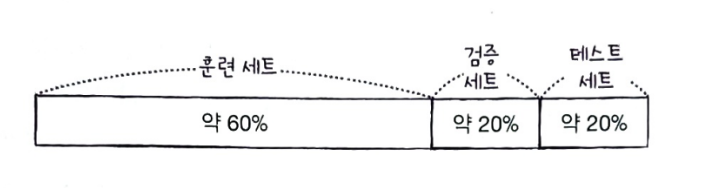

In [ ]:
import pandas as pd

wine = pd.read_csv('https://bit.ly/wine_csv_data')

In [ ]:
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

In [ ]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)

In [ ]:
sub_input, val_input, sub_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

In [ ]:
print(sub_input.shape, val_input.shape)

(4157, 3) (1040, 3)


In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target)

print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))

0.9971133028626413
0.864423076923077


## 교차 검증

데이터를 검증 세트까지 만들어서 훈련 세트가 줄어 들게 됨.
일반적으로 많은 데이터를 훈련에 사용할 수록 좋은 모델이 만들어짐.

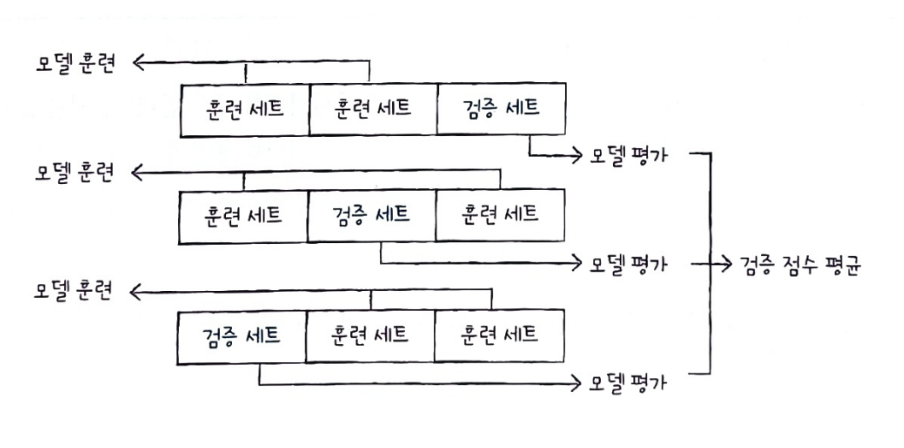

위 예시 이미지는 3-폴드 교차 검증이고  
(훈련 세트를 세 부분으로 나눠서 교차 검증을 진행함)  
5 폴트, 10 폴드를 많이 사용함

사이킷 런에서는 cross_validate를 사용하여 교차 검증을 할 수 있음

In [ ]:
from sklearn.model_selection import cross_validate

scores = cross_validate(dt, train_input, train_target)
print(scores)

NameError: ignored

교차 검증의 최종 점수는 5개의 검수를 평균하여 얻을 수 있음.

In [ ]:
import numpy as np

print(np.mean(scores['test_score']))

0.855300214703487


In [ ]:
from sklearn.model_selection import StratifiedKFold

scores = cross_validate(dt, train_input, train_target, cv=StratifiedKFold())
print(np.mean(scores['test_score']))

0.855300214703487


In [ ]:
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(dt, train_input, train_target, cv=splitter)
print(np.mean(scores['test_score']))

0.8574181117533719


## 하이퍼파라미터 튜닝

for 문으로 할 수 있겠지만, 번거롭기 때문에 이기 만들어진 도구를 사용함.  
(하이퍼파라미터가 매우 많을 경우도 있기 때문에)

AutoML : 사람의 개입 없이 하이퍼파라미터 튜닝을 자동으로 수행해줌.

* 대신 데이터 가공이 엄청 잘 되어 있어야 함 (구글러 피셜)

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'min_impurity_decrease': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}

In [ ]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)

In [ ]:
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
                                                   0.0004, 0.0005]})

In [ ]:
dt = gs.best_estimator_
print(dt.score(train_input, train_target))

0.9615162593804117


어떤 파라미터에서 결과가 좋았는지  
best_prarams 에서 나옴

In [ ]:
print(gs.best_params_)

{'min_impurity_decrease': 0.0001}


In [ ]:
print(gs.cv_results_['mean_test_score'])

[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]


In [ ]:
best_index = np.argmax(gs.cv_results_['mean_test_score'])
print(gs.cv_results_['params'][best_index])

range도 지원함.

In [ ]:
params = {'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001),
          'max_depth': range(5, 20, 1),
          'min_samples_split': range(2, 100, 10)
          }

In [ ]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

In [ ]:
print(gs.best_params_)

{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}


In [ ]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8683865773302731


### 랜덤 서치

내가 간격을 정하기 어려울 경우에 사용.
랜덤한 값이 충분히 쌓이면 해당 범위에서 골고루 나옴.

In [ ]:
from scipy.stats import uniform, randint

In [ ]:
rgen = randint(0, 10)
rgen.rvs(10)

array([4, 7, 6, 8, 9, 3, 8, 3, 1, 4])

0부터 10 까지 1000번 호출하면 각각의 숫자가 100번에 가깝게 호출됨

->

골고루 분포됨

In [ ]:
np.unique(rgen.rvs(1000), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([116, 105,  95, 100,  84,  90,  97,  95, 107, 111]))

In [ ]:
ugen = uniform(0, 1)
ugen.rvs(10)

array([0.07156624, 0.51330724, 0.78244744, 0.14237963, 0.05055468,
       0.13124955, 0.15801332, 0.99110938, 0.08459786, 0.92447632])

In [ ]:
params = {'min_impurity_decrease': uniform(0.0001, 0.001),
          'max_depth': randint(20, 50),
          'min_samples_split': randint(2, 25),
          'min_samples_leaf': randint(1, 25),
          }

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

gs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params,
                        n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7cccce351cc0>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7cccce2f4610>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7cccce352da0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7cccce353bb0>},
                   random_state=42)

In [ ]:
print(gs.best_params_)

{'max_depth': 39, 'min_impurity_decrease': 0.00034102546602601173, 'min_samples_leaf': 7, 'min_samples_split': 13}


In [ ]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8695428296438884


In [ ]:
dt = gs.best_estimator_

print(dt.score(test_input, test_target))

0.86


## 확인문제

In [ ]:
gs = RandomizedSearchCV(DecisionTreeClassifier(splitter='random', random_state=42), params,
                        n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42,
                                                    splitter='random'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7cccce351cc0>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7cccce2f4610>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7cccce352da0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7cccce353bb0>},
                   random_state=42)

In [ ]:
print(gs.best_params_)
print(np.max(gs.cv_results_['mean_test_score']))

dt = gs.best_estimator_
print(dt.score(test_input, test_target))

{'max_depth': 43, 'min_impurity_decrease': 0.00011407982271508446, 'min_samples_leaf': 19, 'min_samples_split': 18}
0.8458726956392981
0.786923076923077
